# Apprentisage Non-Supervisé (Notebook Version)

## Bibliothèques R

In [1]:
#install.packages(c("bigstatsr",
#                   "doParallel",
#                    "parallel",
#                    "factoextra",
#                    "FactoMineR",
#                    "NbClust",
#                    "ggplot2",
#                    "dplyr",
#                    "ggrepel",
#                    "foreach",
#                    "MASS",
#                    "matrixStats",
#                    "devtools",
#                    "Rcpp"))

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
if(!require("RDRToolbox", quietly = TRUE)){
    BiocManager::install("RDRToolbox", version = "3.8")
}else 
    library("RDRToolbox")

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘RDRToolbox’”Bioconductor version 3.8 (BiocManager 1.30.1), R 3.5.1 (2018-07-02)
Installing package(s) 'RDRToolbox'
also installing the dependency ‘rgl’

Warning message in install.packages(pkgs = doing, lib = lib, repos = repos, ...):
“installation of package ‘rgl’ had non-zero exit status”Warning message in install.packages(pkgs = doing, lib = lib, repos = repos, ...):
“installation of package ‘RDRToolbox’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Update old packages: 'bigreadr', 'BiocManager', 'callr', 'car', 'carData',
  'caret', 'checkpoint', 'cli', 'data.table', 'dendextend', 'devtools',
  'digest', 'dimRed', 'doParallel', 'dplyr', 'evaluate', 'fansi', 'foreign',
  'ggplot2', 'ggpubr', 'haven', 'htmlwidgets', 'ipred', 'IRdisplay',
  'IRkernel', 'kernlab', 'later', 'lattice', 'lava', 'lme4', 

In [3]:
library("bigstatsr")
library("doParallel")
library("parallel")
library("factoextra")
library("FactoMineR")
library("NbClust")
library('ggplot2')
library('dplyr')
library("ggrepel")
library("foreach")
library("MASS")
library("matrixStats")
library(caret)
library(e1071)
library(scales)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: ggplot2
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘matrixStats’

The following object is masked from ‘package:dplyr’:

    count

Loading required package: lattice


## Chargement des jeux de données

In [4]:
sequencesimu = "simu.txt"
aiguillage = "aiguillage.txt"

In [5]:
data_sequencesimu <- read.table(sequencesimu,header = FALSE)
data_sequencesimu_mat <- as.matrix(data_sequencesimu)
nbSeqSimu = length(data_sequencesimu_mat)
meanNbSeqSimu = mean(1:nbSeqSimu)
ecNbSeqSimu = sqrt(var(1:nbSeqSimu))

In [6]:
data_aiguillage <- read.table(aiguillage,header = FALSE,sep=",")
data_aiguillage_mat <- as.matrix(data_aiguillage)
data_aiguillage_variable = as.matrix(data_aiguillage[,-553]) 
data_aiguillage_classe = as.matrix(data_aiguillage[,553])
data_aiguillage_classeDF = data_aiguillage[,-553]
NbAiguillage=nrow(data_aiguillage_variable)

# Implémentation de l'Algorithme de Fisher

### La fonction Diamètre

Version 1D

In [7]:
diam <- function(donnees){ 
  n = nrow(donnees)
  D <- matrix(data = 0, nrow = n, ncol = n)    
  for (a in 1:(n-1)){ 
    for (b in (a+1):n){
      D[a,b] <- var(donnees[a:b,])*(b-a+1) 
    }
  }
  D
}

Version nD

In [8]:
diamND <- function(donnees){ 
    n = nrow(donnees)
    D <- matrix(0,n,n)
    foreach(a=1:(n-1)) %do% {
        foreach(b=(a+1):n) %do% {
          D[a,b]= sum(matrixStats::colVars(donnees[a:b,])*(b-a+1))
        }
    }
    D
}

In [9]:
diamND_slow <- function(donnees){ 
    n = nrow(donnees)
    D <- matrix(0,n,n)
    foreach(a=1:(n-1)) %do% {
        foreach(b=(a+1):n) %do% {
          D[a,b]= sum(var(donnees[a:b,])*(b-a+1))
        }
    }
    D
}

### La fonction clustFisher

In [10]:
clustFisher = function(data,kmax=2,diamF=diamND){
    n=nrow(data)

    D=diamF(data)
    M1=matrix(data=0,nrow=n,ncol=kmax)
    M2=matrix(data=0,nrow=n,ncol=kmax)
    M3=matrix(data=0,nrow=n,ncol=kmax)
    M1[,1] = D[1,]

    for(k in 2:kmax){
        for(i in k:n){
            # skip la recherche des sous groupes kmax + 1
            if(k == kmax && i != n) next
            # skip la derniere boucle des sous groupes  quand k<kmax 
            #if(k<kmax && i == n)next
            val=c()

            for( t in k:i){
                val=c(val,M1[t-1, k-1] + D[t, i])
            }
            M1[i,k] = min(val)
            M2[i,k] = which.min(val) + k - 1
            M3[i,k] = M1[i,k]
        }

    }
    
    op=getVarCluster(list(M2=M2,M3=M3,data=data),kmax)
    t=op$t
    vari = op$var

    cluster = getCluster(list(data=data,t=t))
    
    res = list()
    res$t=t
    res$M1=M1
    res$M2=M2
    res$M3=M3
    res$cluster=cluster
    res$data=data
    res$diam=D
    res$var = vari
    res
}
getCluster = function(cf){
    o=0
    curr=0
    n=nrow(cf$data)
    cluster=c()
    for (i in cf$t){
        cluster=c(cluster,rep(o,i-curr))
        curr=i
        o=o+1
    }
    cluster=c(cluster,rep(o,n-curr))
    cluster
}
getVarCluster = function(cf,kmax,withClusters=FALSE){
    n=nrow(cf$data)
    t=rep(0,time=(kmax-1))
        k=kmax-1
        m=n
        vari = NULL
        while(k >=1) {
           t[k] =  cf$M2[m, k +1 ] - 1
           if(is.null(vari)) vari = cf$M3[m, k  +1]
           m = t[k] 
           k=k-1
        }
    res=list()
    res$var=vari
    res$t=t
    if(withClusters) res$clusters= getCluster(list(t=t,data=cf$data))
    res
}

### Fonction pour trouver les variances pour toutes les classes jusqu'a n_clust

In [11]:
getVarAndFisher=function(data,n_clust=10){
    clust10 = clustFisher(data,n_clust)
    frz= sapply(2:n_clust,function(i)getVarCluster(clust10,i)$var)
    df=data.frame(unlist(matrix(frz)))
    df=cbind(2:n_clust,df)
    colnames(df) = c("index","V1")
    rownames(df)=df$index
    list(clust10=clust10,df=df)
}

# SequenceSimu

## Comparaison des 3 algorithmes CAH Ward, Kmeans, et l'algorithme de Fisher

Il y a 210 lignes et 1 colonnes

In [12]:
dim(data_sequencesimu_mat)

[1] 210   1

## Graphiques Du jeux de données  

On arrive deja à avoir une certaine idée des clusters (5 clusters) avec le graphique

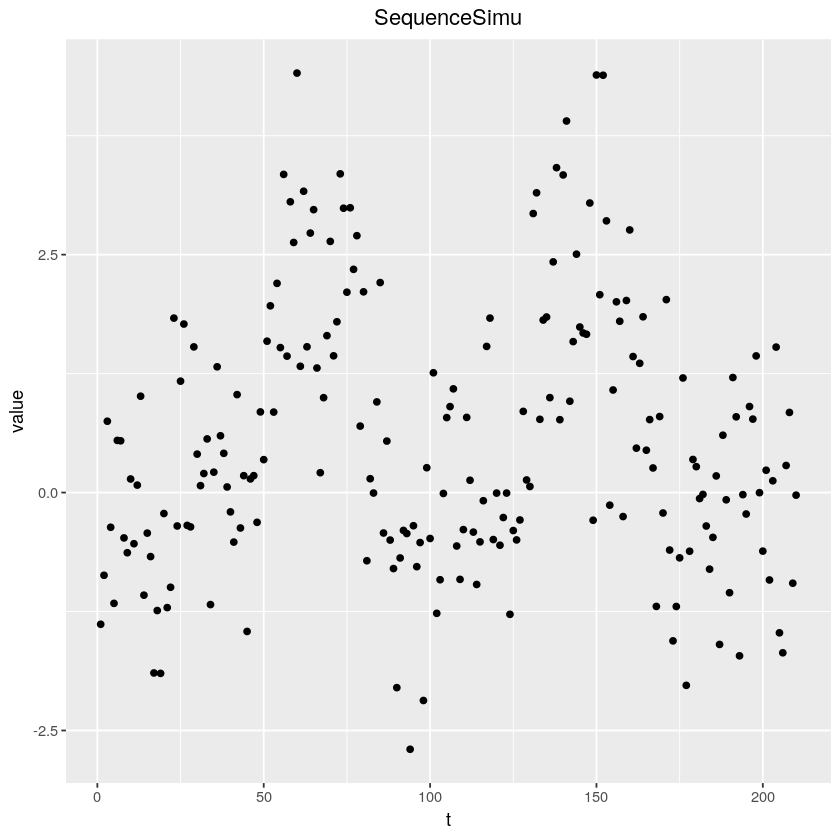

In [13]:
data_sequencesimu %>% ggplot(aes(x=1:nbSeqSimu,y=V1)) +
                                                    geom_point() +
                                                    xlab("t") + 
                                                    ylab("value") + 
                                                    ggtitle("SequenceSimu") + 
                                                    theme(plot.title = element_text(hjust = 0.5))

## Application de l'algo de Fisher

### Données Brutes

In [14]:
n_clust=10

In [15]:
getBru = function(force=F,autoSave=T){
    if(file.exists("bru.Rdata")){
        if(!force){
            load("bru.Rdata")
            return(bru)
        }
    }
    bru=getVarAndFisher(data_sequencesimu_mat,n_clust)
    if(autoSave)save(bru,file="bru.Rdata")
    return(bru)
}
bru = getBru()

In [16]:
bru

"0,0000000","0,0000000","0,0000000","0,0000000","0,0000000","0,000000e+00","0,000000e+00","0,000000e+00","0,000000e+00",0
"0,2648464","0,0000000","0,0000000","0,0000000","0,0000000","0,000000e+00","0,000000e+00","0,000000e+00","0,000000e+00",0
"3,7182758","0,2648464","0,0000000","0,0000000","0,0000000","0,000000e+00","0,000000e+00","0,000000e+00","0,000000e+00",0
"3,3237617","1,5063566","0,2648464","0,0000000","0,0000000","0,000000e+00","0,000000e+00","0,000000e+00","0,000000e+00",0
"3,6020920","2,8350916","0,9041205","0,2648464","0,0000000","0,000000e+00","0,000000e+00","0,000000e+00","0,000000e+00",0
"4,7910192","3,3811961","2,4670500","0,9041205","0,2648464","0,000000e+00","0,000000e+00","0,000000e+00","0,000000e+00",0
"5,5753279","3,5483135","2,8351103","0,9041392","0,2648652","1,873148e-05","0,000000e+00","0,000000e+00","0,000000e+00",0
"5,5013062","3,7076243","2,9456946","1,9497247","0,9041392","2,648652e-01","1,873148e-05","0,000000e+00","0,000000e+00",0
"5,5242321","3,9777338","3,0404073","2,5344406","0,9283195","2,890455e-01","2,419905e-02","1,873148e-05","0,000000e+00",0
"5,6877810","3,9676728","3,1234906","2,4541015","1,4080345","7,687605e-01","2,890455e-01","2,419905e-02","1,873148e-05",0
"5,6918395","4,1175834","3,1787628","2,7086891","1,3984746","7,592006e-01","4,943541e-01","2,890455e-01","2,419905e-02",0


In [17]:
df=bru$df
clustBru=bru$clust10

La variance de chaque cluster allant de 2 à 10 

In [18]:
df[1:10,]

,index,V1
2,2,"381,7733"
3,3,"312,8888"
4,4,"285,7190"
5,5,"203,2420"
6,6,"195,4026"
7,7,"189,2766"
8,8,"183,7358"
9,9,"177,8797"
10,10,"173,9254"
NA,NA,NA


### Méthode du coude

### Données Brutes

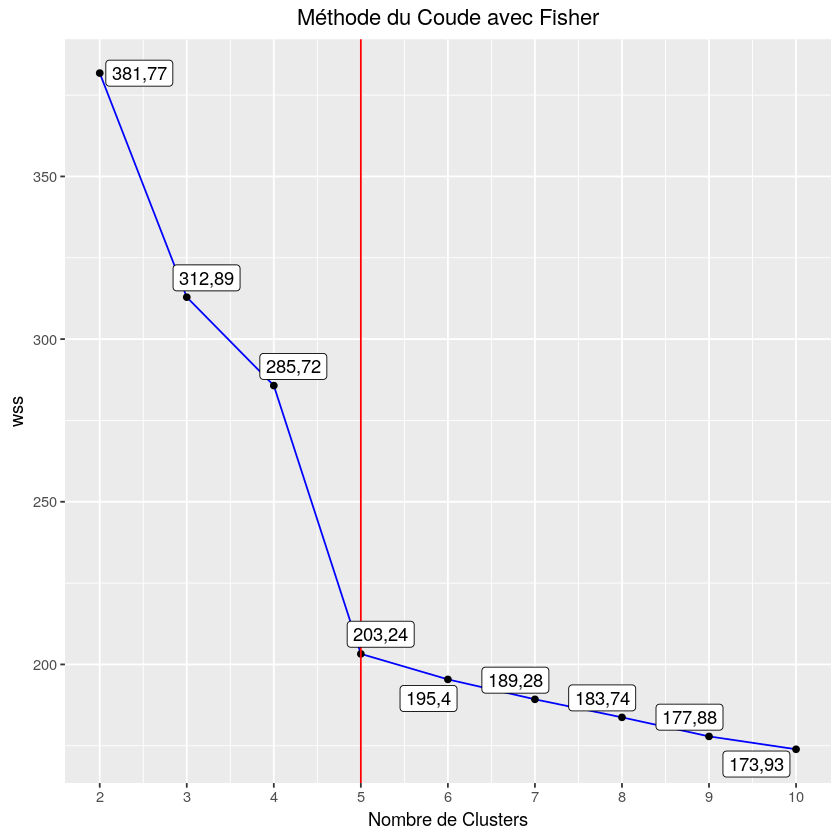

In [19]:
df %>% ggplot(aes(x=2:n_clust,y=V1)) + 
                                    ggtitle("Méthode du Coude avec Fisher") + 
                                    geom_line(col="blue")  + 
                                    geom_point() + 
                                    xlab("Nombre de Clusters") +
                                    ylab("wss") +
                                    scale_x_continuous(breaks = 2:n_clust) +
                                    geom_vline(xintercept = 5,col="red") + 
                                    geom_label_repel(aes(label=round(V1,2))) + 
                                    theme(plot.title = element_text(hjust = 0.5))

On voit qu'il faut choisir 5 pour le choix du nombre de classes

### Representation des clusters

Fonction pour l'affichage

In [20]:
addLine = function(ggplotFig,meanV=meanNbSeqSimu,ecV=ecNbSeqSimu,title=""){
    plotFig=ggplotFig + 
    geom_point() + 
    xlab("row") + 
    ylab("value")
    for(i in cl$t){
        plotFig=plotFig+geom_vline(xintercept = (i-meanV)/ecV,col="red")
    }
     
    plotFig+
        ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5)) 
                                                        
}

Recuperation des clusters pour 5 

In [21]:
cl=getVarCluster(clustBru,5,withClusters = T)

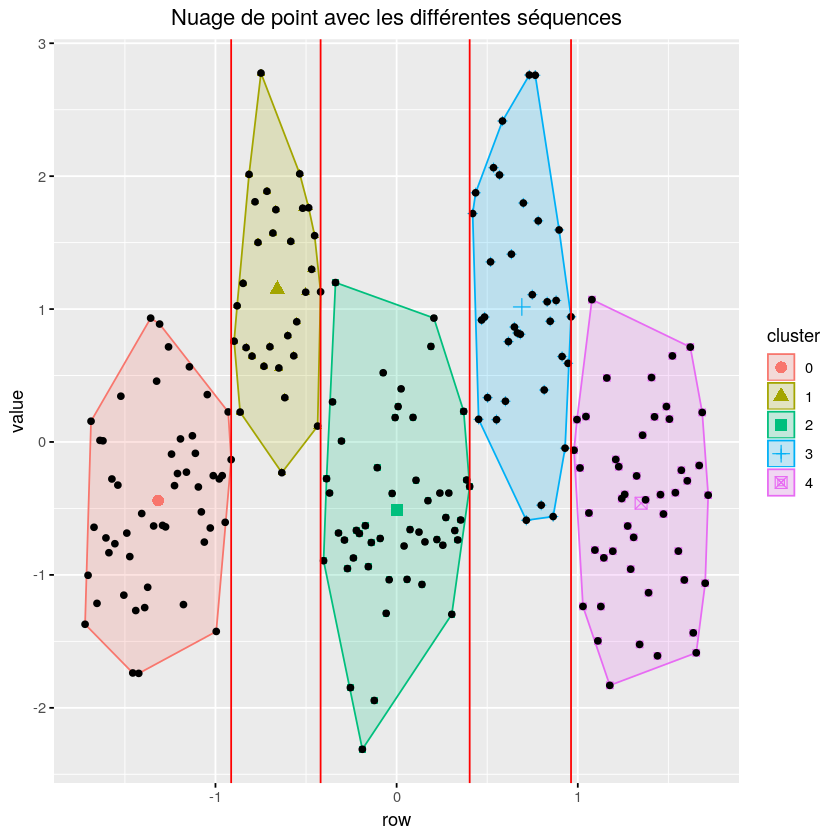

In [22]:
addLine(fviz_cluster(show.clust.cent = T,labelsize = 0,list(data = as.data.frame(
                                        cbind(1:nrow(data_sequencesimu_mat),data_sequencesimu_mat)
                                      ), 
                  cluster = cl$cluster
                ))
        ,title="Nuage de point avec les différentes séquences")

### Kmeans sur le jeux de données de Simulation 

In [23]:
nbc=fviz_nbclust(data_sequencesimu,kmeans,k.max = n_clust,method = "wss")

In [24]:
nbc$data

clusters,y
1,"407,637283"
2,"132,362203"
3,"73,167969"
4,"40,026657"
5,"26,284271"
6,"18,992022"
7,"17,487605"
8,"11,772158"
9,"8,502691"
10,"9,983445"


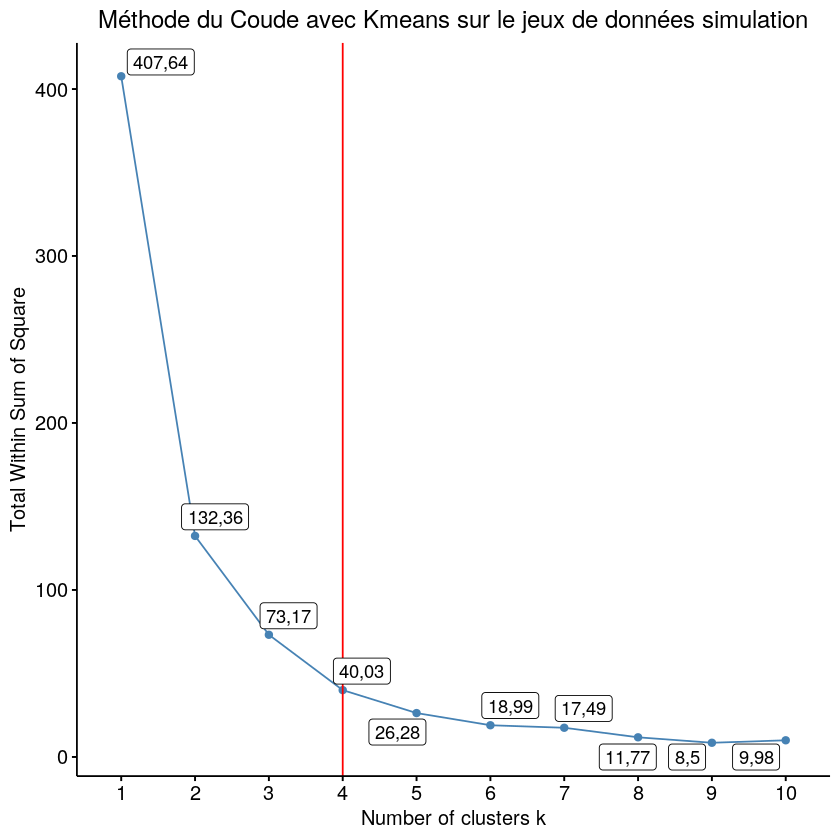

In [25]:
nbc + 
    geom_vline(xintercept = 4,col="red") + 
    ggtitle("Méthode du Coude avec Kmeans sur le jeux de données simulation") + 
    geom_label_repel(aes(label=round(nbc$data$y,2))) +
    theme(plot.title = element_text(hjust = 0.5)) 

Nous utiliserons le nombre de cluster fixé à 4

In [26]:
cluster_kmeans=kmeans(data_sequencesimu,4)

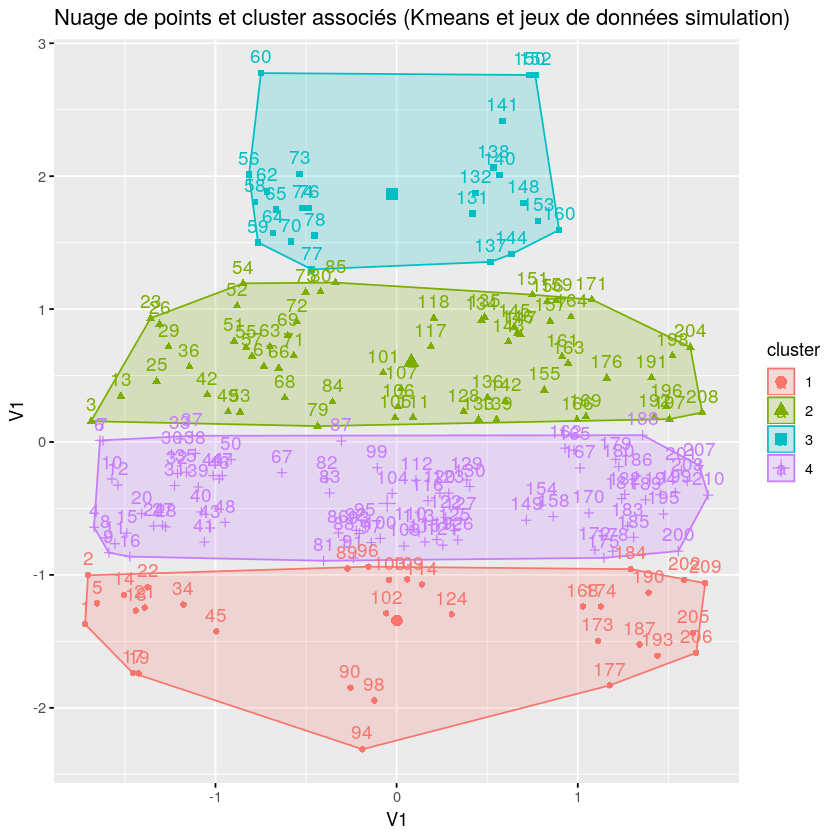

In [27]:
fviz_cluster(list(data = as.data.frame(cbind(1:nbSeqSimu,data_sequencesimu_mat)), 
                  cluster = cluster_kmeans$cluster),
             main="Nuage de points et cluster associés (Kmeans et jeux de données simulation)")

### La classification ascendante hiérarchique (Ward)

In [28]:
nbc=fviz_nbclust(data_sequencesimu,hcut,k.max = n_clust,method = "wss")

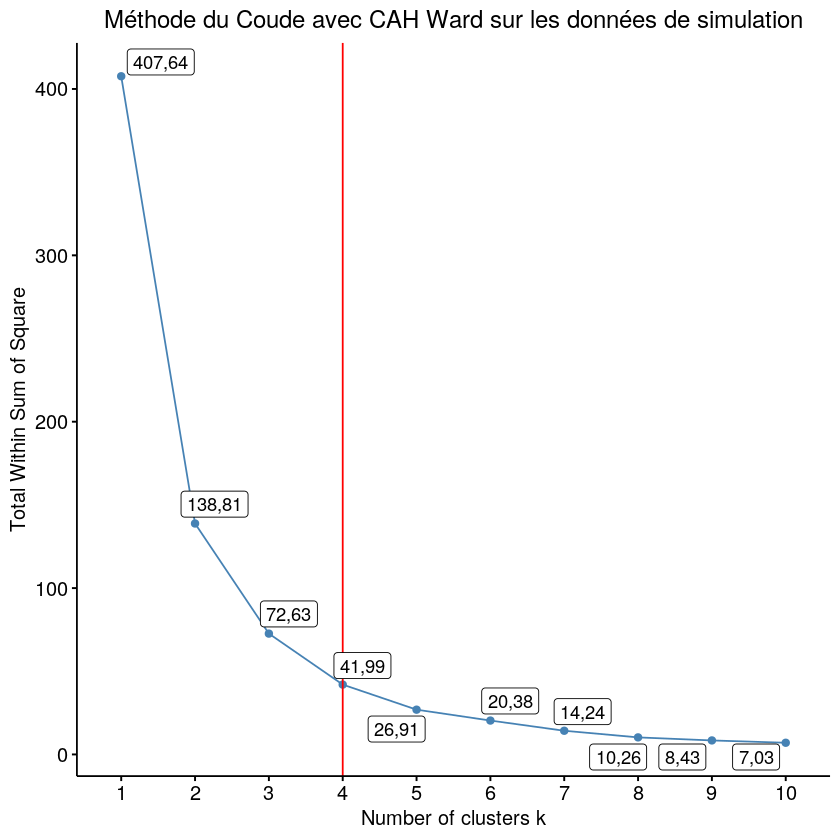

In [29]:
nbc + 
    geom_vline(xintercept = 4,col="red") + 
    ggtitle("Méthode du Coude avec CAH Ward sur les données de simulation") + 
    geom_label_repel(aes(label=round(nbc$data$y,2))) +
    theme(plot.title = element_text(hjust = 0.5)) 

Nous utiliserons le nombre de cluster fixé à 4

In [30]:
hv=hcut(data_sequencesimu,4)

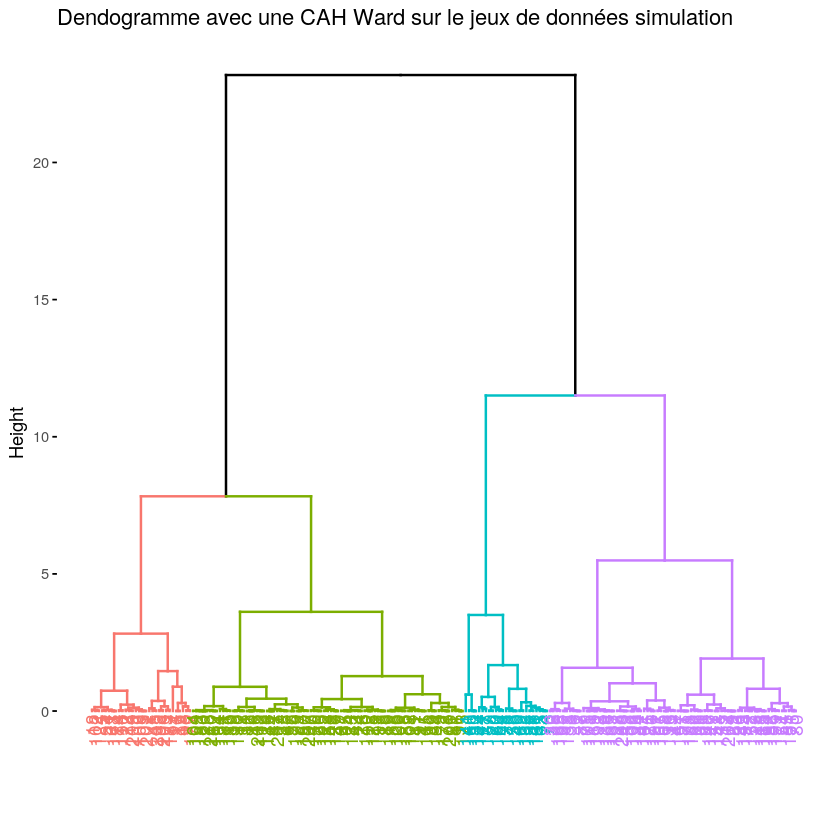

In [31]:
fviz_dend(hv,4,main="Dendogramme avec une CAH Ward sur le jeux de données simulation")

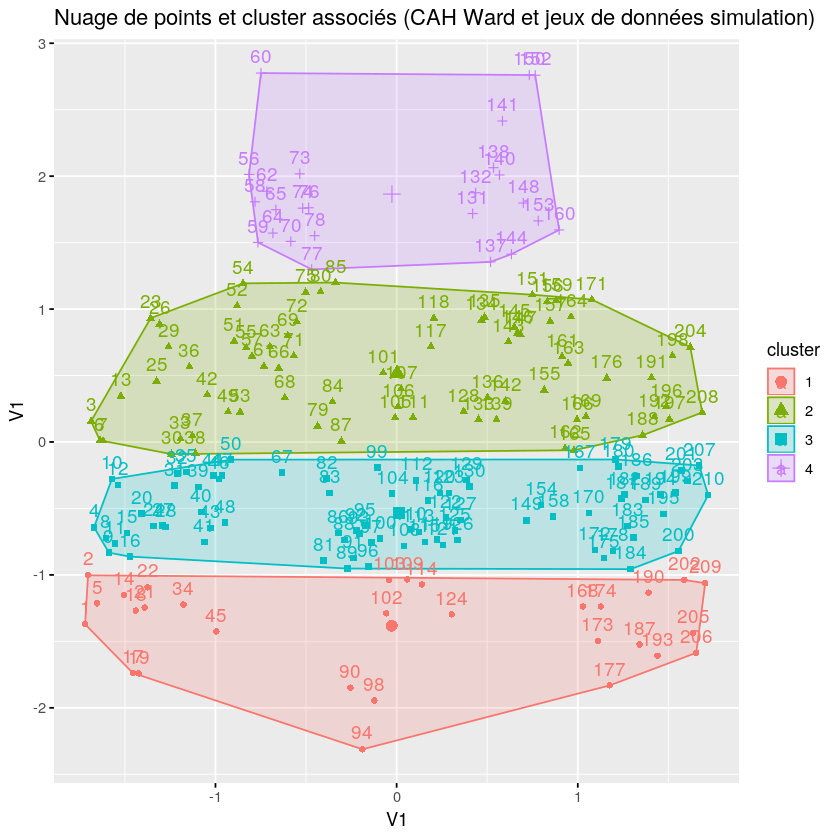

In [32]:
fviz_cluster(list(data = as.data.frame(cbind(1:length(data_sequencesimu_mat),data_sequencesimu_mat)), 
                  cluster = hv$cluster),
             main="Nuage de points et cluster associés (CAH Ward et jeux de données simulation)")

# Aiguillage

## Comparaison des 3 algorithmes CAH Ward, Kmeans, et l'algorithme de Fisher

Il y a 140 lignes et 553 colonnes

In [33]:
dim(data_aiguillage_mat)

[1] 140 553

Il y a 4 classes

In [34]:
as.data.frame(table(data_aiguillage_classe))

data_aiguillage_classe,Freq
1,35
2,40
3,45
4,20


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


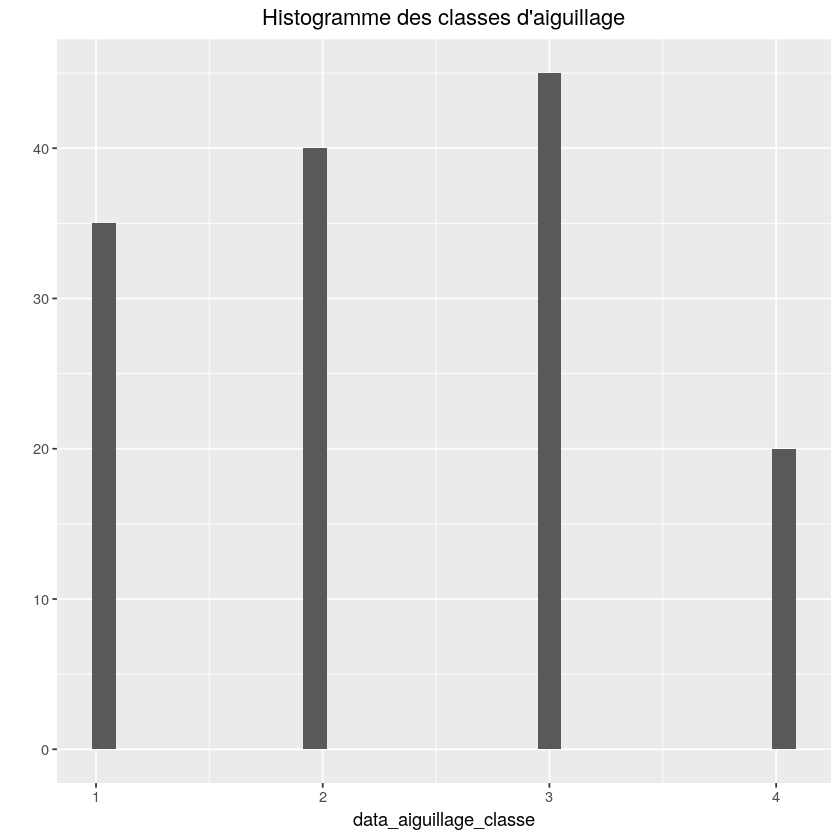

In [35]:
qplot(data_aiguillage_classe, geom="histogram") +
ggtitle("Histogramme des classes d'aiguillage") + 
theme(plot.title = element_text(hjust = 0.5))

## Graphiques

V1 au cours du temps

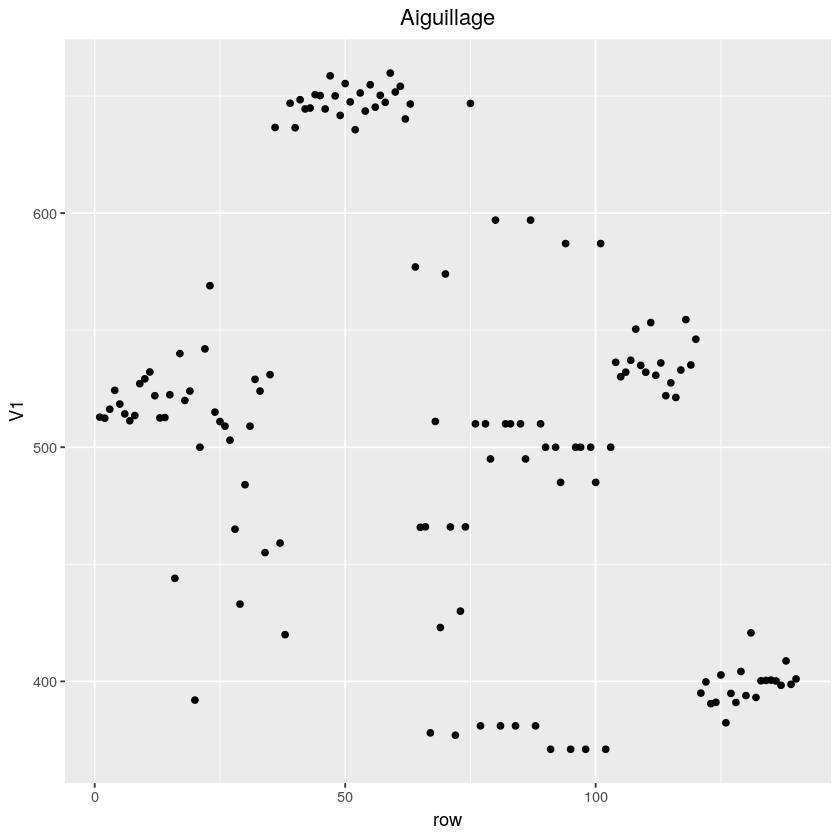

In [36]:
as.data.frame(data_aiguillage_variable) %>% ggplot(aes(x=1:NbAiguillage,y=V1)) + 
                                                                geom_point() + 
                                                                xlab("row") + 
                                                                ylab("V1") + 
                                                                ggtitle("Aiguillage") + 
                                                                theme(plot.title = element_text(hjust = 0.5))

Visuellement nous pouvons constater qu'il y a 4 séquences.

## Algorithme de Fisher

In [37]:
n_clust = 10

In [38]:
test = clustFisher(as.matrix(data_aiguillage_variable),4)

In [39]:
test$cluster

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

In [40]:
opF = getVarAndFisher(as.matrix(data_aiguillage_variable),n_clust)

In [41]:
df = opF$df
clustFish = opF$clust10

In [42]:
cl=getVarCluster(clustFish,4,withClusters = T)

In [43]:
# Table de confusion 
tab <- table(test$cluster+1,data_aiguillage_classe)
print(tab)
prop.table(tab)

   data_aiguillage_classe
     1  2  3  4
  1 35  0  0  0
  2  0 40  0  0
  3  0  0 45  0
  4  0  0  0 20


   data_aiguillage_classe
            1         2         3         4
  1 0,2500000 0,0000000 0,0000000 0,0000000
  2 0,0000000 0,2857143 0,0000000 0,0000000
  3 0,0000000 0,0000000 0,3214286 0,0000000
  4 0,0000000 0,0000000 0,0000000 0,1428571

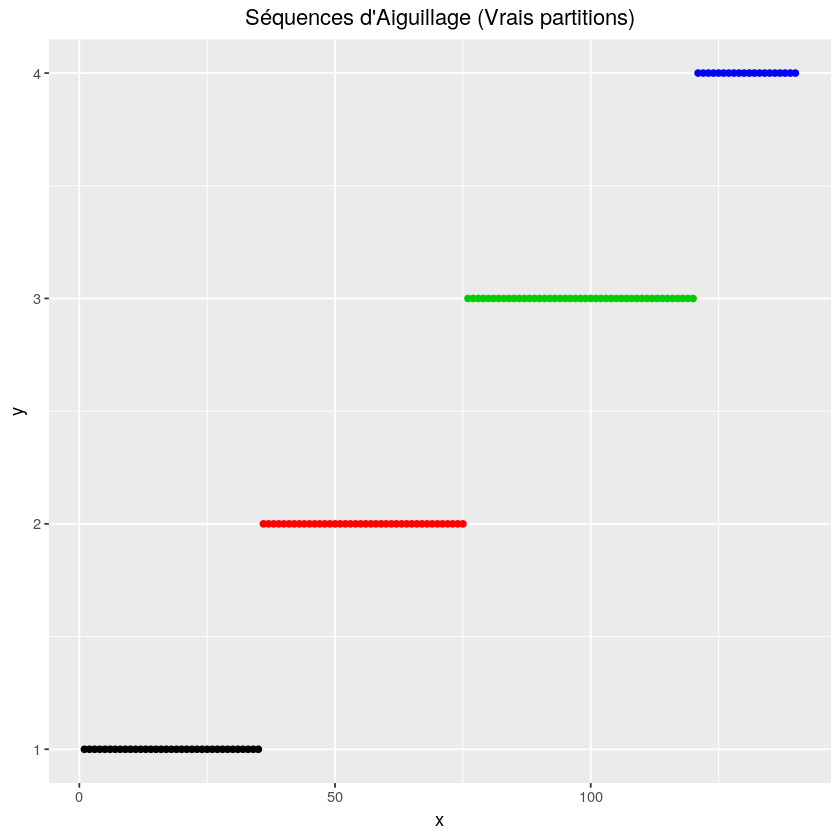

In [44]:
d=data.frame(x=1:nrow(data_aiguillage_classe),y=cl$clusters+1)
d %>% ggplot() + geom_point(aes(x=x,y=y),color=data_aiguillage_classe) + ggtitle("Séquences d'Aiguillage (Vrais partitions)") + 
                                                                theme(plot.title = element_text(hjust = 0.5))  

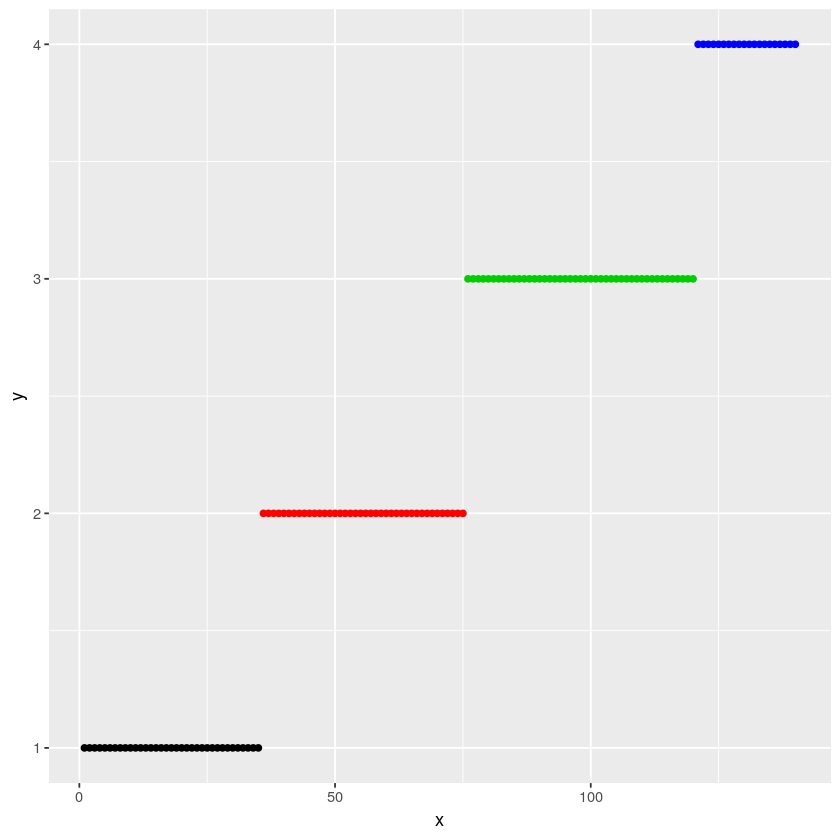

In [45]:
d=data.frame(x=1:nrow(data_aiguillage_classe),y=data_aiguillage_classe)
d %>% ggplot() + geom_point(aes(x=x,y=y),color=data_aiguillage_classe)

### Kmeans avec 4 clusters sur les données Aiguillage

D'après la méthode du coude, nous aurions tendance à dire qu'il y 2 groupement.

In [46]:
cluster_kmeans=kmeans(data_aiguillage_variable,4)

In [47]:
cluster_kmeans$cluster

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3
 [75] 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

In [48]:
clustFish

"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00",0
"41875,68","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00",0
"56467,11","34816,58","0,00","0,00","0,00","0,00","0,00","0,00","0,00",0
"76738,38","54243,19","34816,58","0,00","0,00","0,00","0,00","0,00","0,00",0
"99407,69","76738,38","54243,19","34816,58","0,00","0,00","0,00","0,00","0,00",0
"118078,05","98001,22","76738,38","54243,19","34816,58","0,00","0,00","0,00","0,00",0
"138047,36","118078,05","98001,22","76738,38","54243,19","34816,58","0,00","0,00","0,00",0
"157021,68","137091,92","118078,05","98001,22","76738,38","54243,19","34816,58","0,00","0,00",0
"178397,07","157021,68","137091,92","118078,05","98001,22","76738,38","54243,19","34816,58","0,00",0
"197321,88","177103,04","157021,68","137091,92","118078,05","97943,88","76738,38","54243,19","34816,58",0
"217223,42","196881,52","177103,04","157021,68","137091,92","117267,04","97572,53","76738,38","54243,19",0


In [49]:
d = table(cluster_kmeans$cluster,data_aiguillage_classe)
d

   data_aiguillage_classe
     1  2  3  4
  1 34  2  0  0
  2  0  0 45  0
  3  1 38  0  0
  4  0  0  0 20

In [50]:
# Table de confusion 
tab <- table(cluster_kmeans$cluster,data_aiguillage_classe)
print(tab)
prop.table(tab)

   data_aiguillage_classe
     1  2  3  4
  1 34  2  0  0
  2  0  0 45  0
  3  1 38  0  0
  4  0  0  0 20


   data_aiguillage_classe
              1           2           3           4
  1 0,242857143 0,014285714 0,000000000 0,000000000
  2 0,000000000 0,000000000 0,321428571 0,000000000
  3 0,007142857 0,271428571 0,000000000 0,000000000
  4 0,000000000 0,000000000 0,000000000 0,142857143

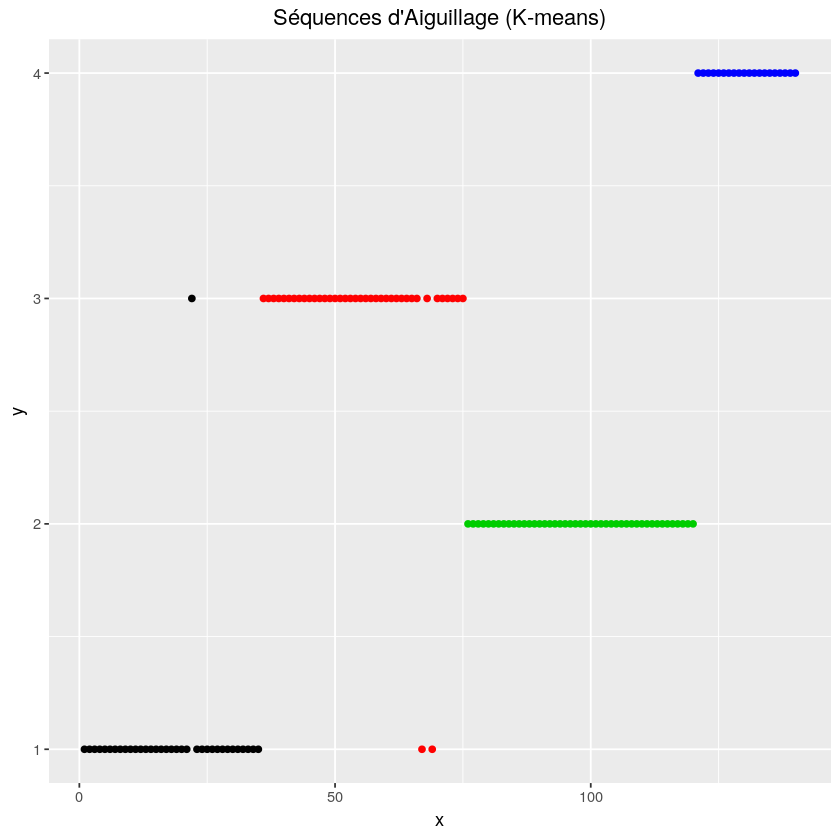

In [51]:
d=data.frame(x=1:nrow(data_aiguillage_classe),y=cluster_kmeans$cluster)
d %>% ggplot() + geom_point(aes(x=x,y=y),color=data_aiguillage_classe)  + ggtitle("Séquences d'Aiguillage (K-means)") + 
                                                                theme(plot.title = element_text(hjust = 0.5)) 

In [52]:
hv=hcut(data_aiguillage_variable,4)

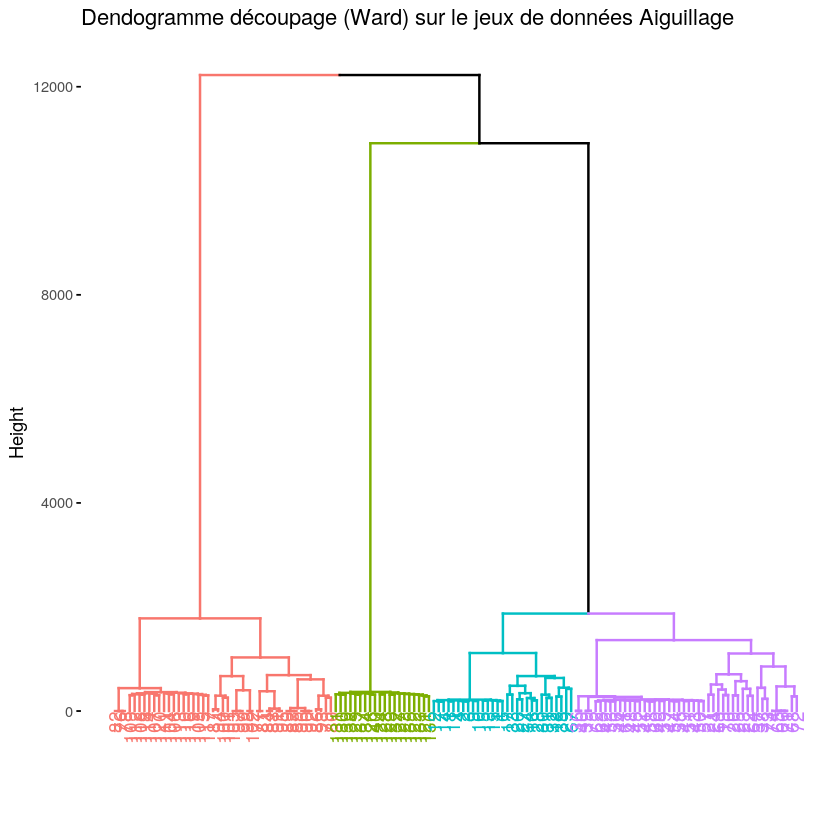

In [53]:
fviz_dend(hv,main="Dendogramme découpage (Ward) sur le jeux de données Aiguillage")

In [54]:
table(hv$cluster)


 1  2  3  4 
29 46 45 20 

In [55]:
tab <- table(hv$cluster,data_aiguillage_classe)
print(tab)
prop.table(tab)

   data_aiguillage_classe
     1  2  3  4
  1 28  1  0  0
  2  7 39  0  0
  3  0  0 45  0
  4  0  0  0 20


   data_aiguillage_classe
              1           2           3           4
  1 0,200000000 0,007142857 0,000000000 0,000000000
  2 0,050000000 0,278571429 0,000000000 0,000000000
  3 0,000000000 0,000000000 0,321428571 0,000000000
  4 0,000000000 0,000000000 0,000000000 0,142857143

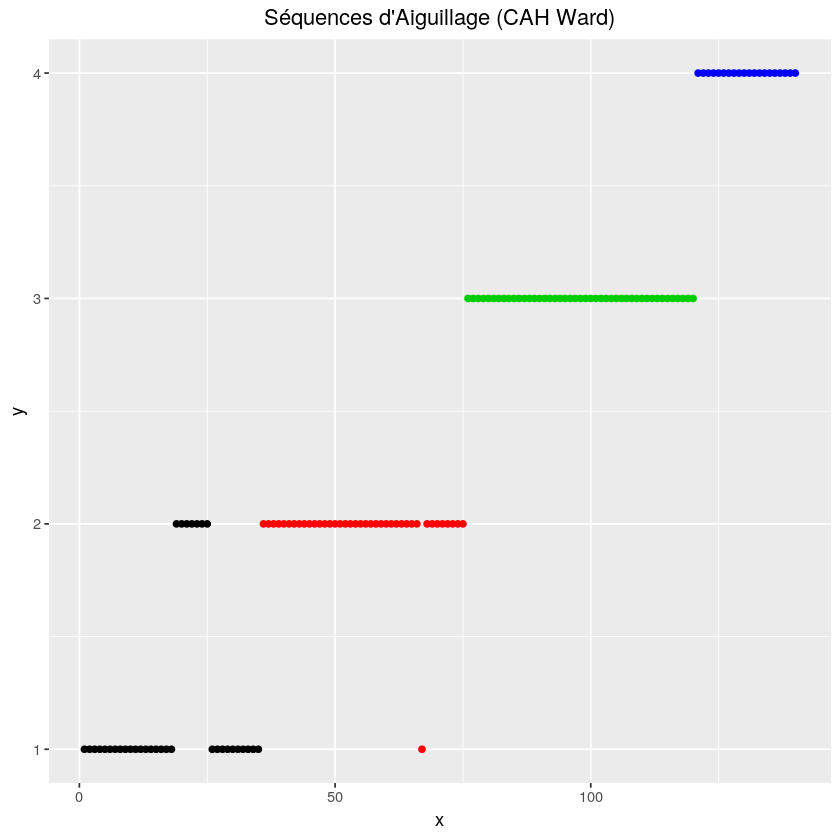

In [56]:
d=data.frame(x=1:nrow(data_aiguillage_classe),y=hv$cluster)
d %>% ggplot() + geom_point(aes(x=x,y=y),color=data_aiguillage_classe) + ggtitle("Séquences d'Aiguillage (CAH Ward)") + 
                                                                theme(plot.title = element_text(hjust = 0.5)) 

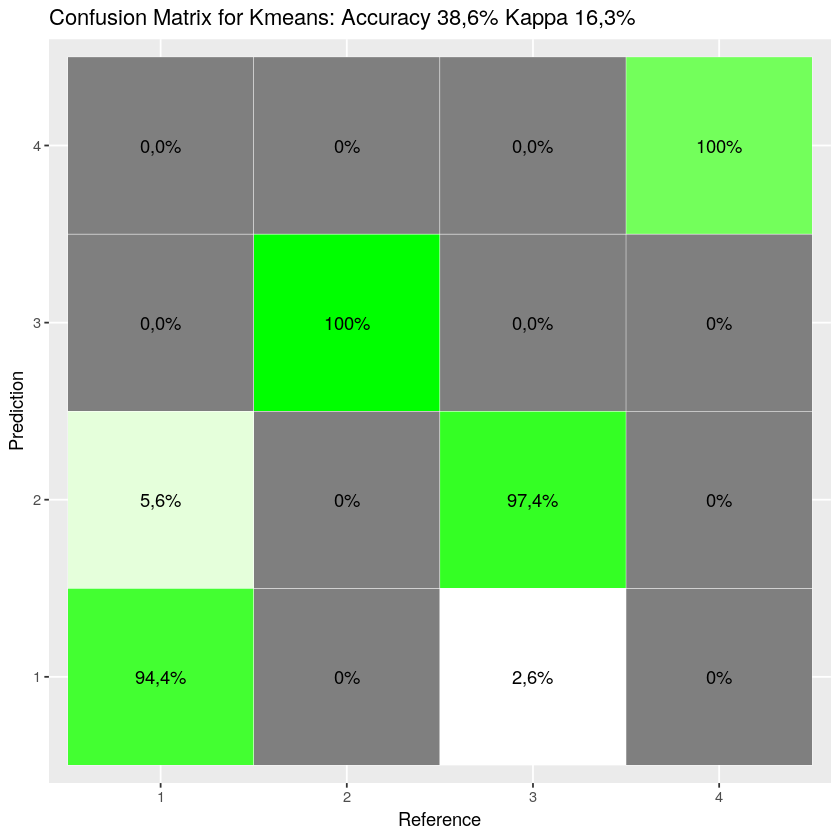

In [57]:
valid_actual <- as.factor(data_aiguillage_classe)

valid_pred   <- as.factor(cluster_kmeans$cluster)

cfm <- confusionMatrix(valid_actual, valid_pred)

ggplotConfusionMatrix <- function(m){
  mytitle <- paste("Confusion Matrix for Kmeans:","Accuracy", percent_format()(m$overall[1]),
                   "Kappa", percent_format()(m$overall[2]))
  data_c <-  mutate(group_by(as.data.frame(m$table), Reference ), percentage = 
percent(Freq/sum(Freq)))
  p <-
    ggplot(data = data_c,
           aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = log(Freq)), colour = "white") +
    scale_fill_gradient(low = "white", high = "green") +
    geom_text(aes(x = Reference, y = Prediction, label = percentage)) +
    theme(legend.position = "none") +
    ggtitle(mytitle)
  return(p)
}

ggplotConfusionMatrix(cfm)

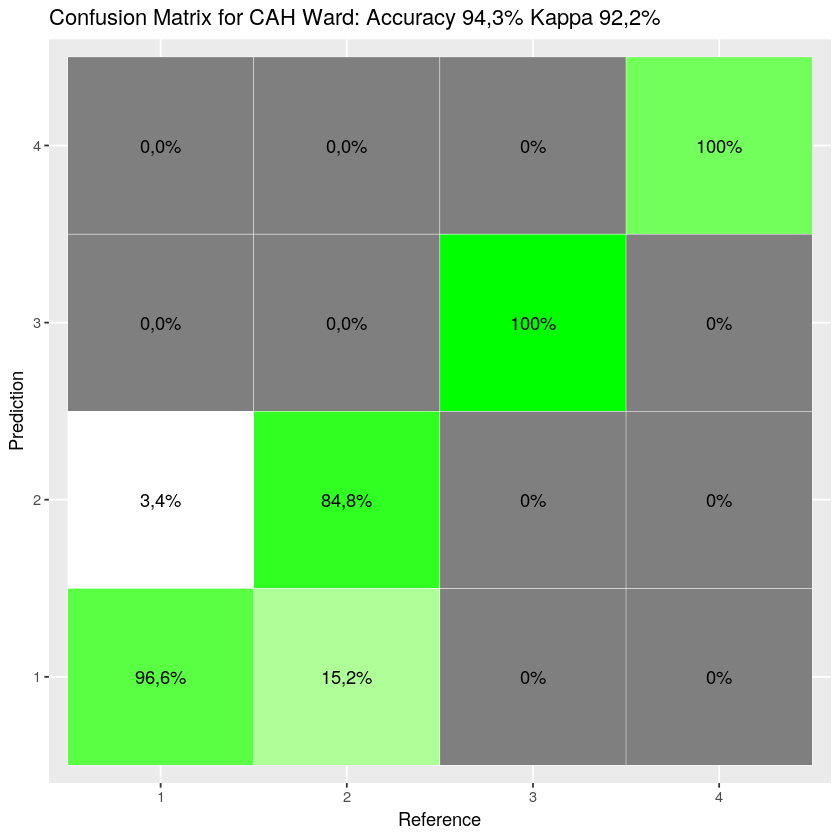

In [58]:
valid_actual <- as.factor(data_aiguillage_classe)

valid_pred   <- as.factor(hv$cluster)

cfm <- confusionMatrix(valid_actual, valid_pred)

ggplotConfusionMatrix <- function(m){
  mytitle <- paste("Confusion Matrix for CAH Ward:","Accuracy", percent_format()(m$overall[1]),
                   "Kappa", percent_format()(m$overall[2]))
  data_c <-  mutate(group_by(as.data.frame(m$table), Reference ), percentage = 
percent(Freq/sum(Freq)))
  p <-
    ggplot(data = data_c,
           aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = log(Freq)), colour = "white") +
    scale_fill_gradient(low = "white", high = "green") +
    geom_text(aes(x = Reference, y = Prediction, label = percentage)) +
    theme(legend.position = "none") +
    ggtitle(mytitle)
  return(p)
}

ggplotConfusionMatrix(cfm)

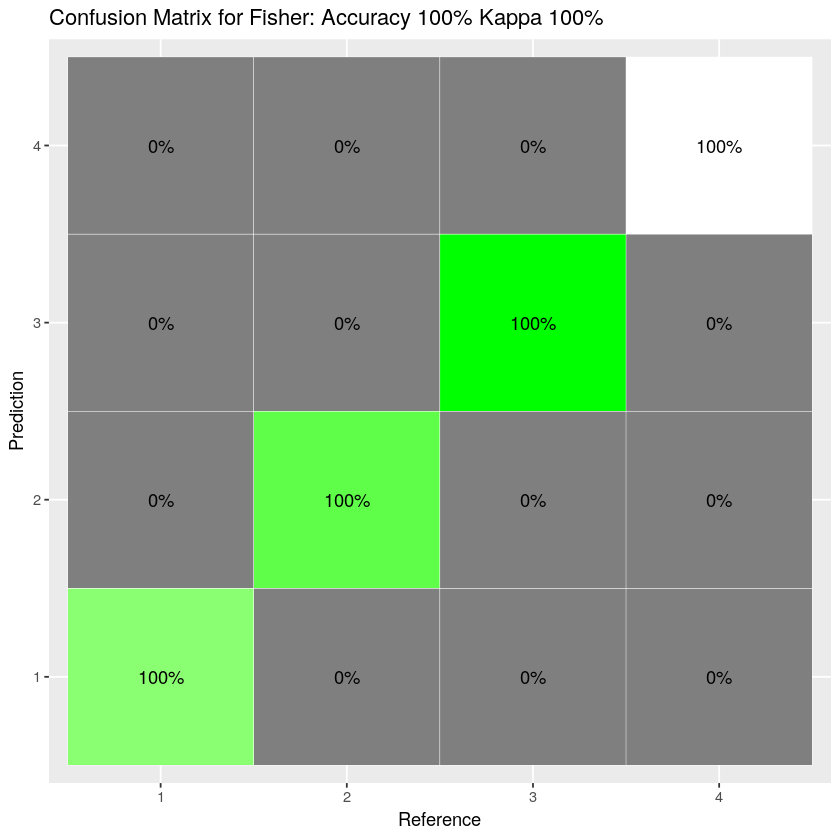

In [59]:
valid_actual <- as.factor(data_aiguillage_classe)

valid_pred   <- as.factor(cl$clusters+1)

cfm <- confusionMatrix(valid_actual, valid_pred)

ggplotConfusionMatrix <- function(m){
  mytitle <- paste("Confusion Matrix for Fisher:","Accuracy", percent_format()(m$overall[1]),
                   "Kappa", percent_format()(m$overall[2]))
  data_c <-  mutate(group_by(as.data.frame(m$table), Reference ), percentage = 
percent(Freq/sum(Freq)))
  p <-
    ggplot(data = data_c,
           aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = log(Freq)), colour = "white") +
    scale_fill_gradient(low = "white", high = "green") +
    geom_text(aes(x = Reference, y = Prediction, label = percentage)) +
    theme(legend.position = "none") +
    ggtitle(mytitle)
  return(p)
}

ggplotConfusionMatrix(cfm)

In [71]:
c_fast = vector(length=5)
for (a in 2:6){ 
      c_fast[a-1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable),a,diamF=diamND))
  }

Warning message in c_fast[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_fast[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_fast[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_fast[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_fast[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”

In [73]:
c_fast

[1] 4,744 4,591 4,788 4,667 4,751

In [74]:
c_slow = vector(length=5)
for (a in 2:6){ 
      c_slow[a-1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable),a,diamF=diamND_slow))
  }

Warning message in c_slow[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_slow[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_slow[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_slow[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”Warning message in c_slow[a - 1] <- system.time(clustFisher(as.matrix(data_aiguillage_variable), :
“number of items to replace is not a multiple of replacement length”

In [116]:
c_slow

[1]  96,123  96,788  98,952 100,200 100,093

In [164]:
mean(c_slow/c_fast)

[1] 20,90969

In [117]:
row_names = c(2,3,4,5,6)

In [118]:
row_names

[1] 2 3 4 5 6

In [132]:
r <- data.frame(matrixStats=c_fast,var=c_slow,number_clusters=c(2:6))

In [133]:
r

matrixStats,var,number_clusters
"4,744","96,123",2
"4,591","96,788",3
"4,788","98,952",4
"4,667","100,200",5
"4,751","100,093",6


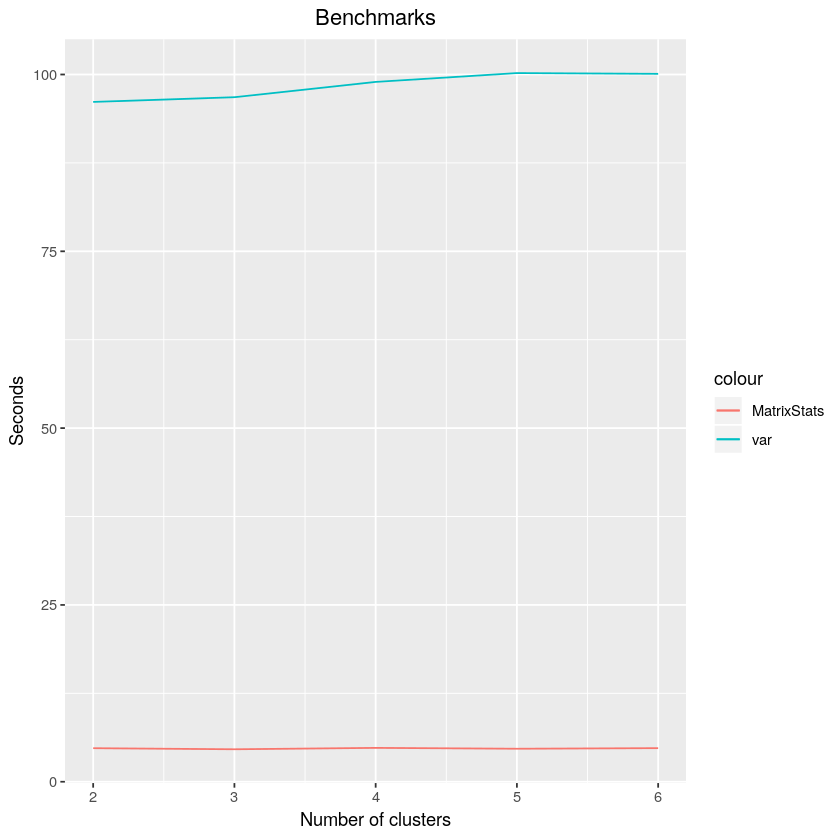

In [157]:
r %>% ggplot() + geom_line(aes(x=r$number_clusters,y=r$var,colour = "var"))  + 
                 geom_line(aes(x=r$number_clusters,y=r$matrixStats,colour = "MatrixStats")) +
                 ggtitle("Benchmarks") + 
                 xlab("Number of clusters") + 
                 ylab("Seconds") + 
                 theme(plot.title = element_text(hjust = 0.5)) 

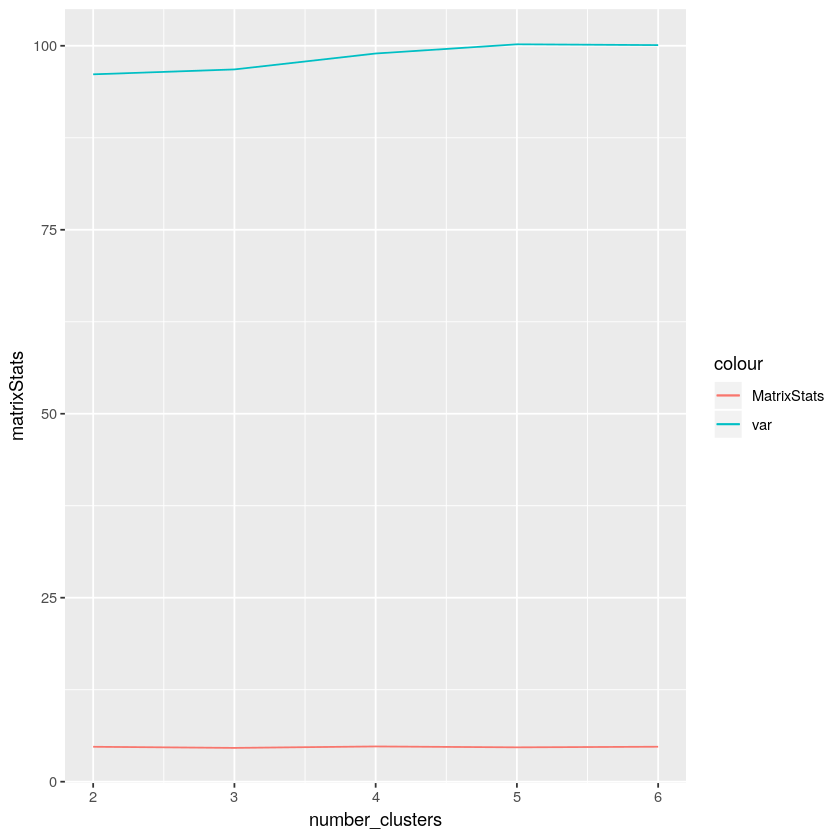

In [142]:
ggplot(r, aes(number_clusters)) + 
  geom_line(aes(y = matrixStats, colour = "MatrixStats")) + 
  geom_line(aes(y = var, colour = "var"))